# Exemples de classification avec scikit-learn

On va effectuer un apprentissage supervisé multi-classes avec différentes méthodes de la librairie **scikit-learn** :
- Régression logistique
- Arbres de décision
- Forêts d'arbres décisionnels
- K plus proches voisins
- Algorithme du gradient stochastique
- Machine à vecteurs de support
- Classification naïve bayésienne
- Réseau de neuronnes

Avec **scikit-learn**, le principe est toujours le même :
- Matrice de données *X* et vecteur d'étiquettes *y*
- Séparation des bases d'apprentissage et de test : *X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, ...)*
- Instanciation d'un algorithme de classification : *algo = XClassifier(...)*
- Apprentissage sur la base d'apprentissage : *algo.fit(X_train, y_train)*
- Prédiction sur la base de test : *y_pred = algo.predict(X_test)*
- Calcul de la performance en comparant y_pred avec y_test : *accuracy_score(y_test, y_pred)*

In [8]:
# imports usuels
import numpy as np
import pandas as pnd
import matplotlib.pyplot as plt
%matplotlib inline

# chargement des algorithmes scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# utilisatires scikit-learn
from sklearn.datasets import fetch_mldata
from sklearn import model_selection
from sklearn.metrics import accuracy_score

# timer
import timeit

## Chargement des données

Cet exemple utilise un dataset du MNIST voir : http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

In [9]:
from IPython.display import IFrame
IFrame("http://yann.lecun.com/exdb/mnist/", 800, 400)

In [10]:
# import du dataset de 70.000 images en niveau de gris
# écriture manuscripte des chiffres de 0 à 9
# images étiquettées
mnist = fetch_mldata("MNIST original")

# rescale the data
X, y = mnist.data / 255., mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


In [11]:
# images carrées de 28 x 28 pixels
np.sqrt(784)

28.0

## Affichage des données

In [12]:
# adapté du MOOC machine learning Coursera Octave displayData.m
# et étendu avec l'affichage des chiffres en parallèle des images
# et également des écarts des prédictions

def display_data(X, y=None, y_predict=None):
    example_width = int(np.sqrt(X.shape[1]))

    # Compute rows, cols
    m, n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),\
                           pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    # dataset contains N pixel by N pixel grayscale images of the digit 
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex]))
            display_array[(pad + j * (example_height + pad)):(pad + j * (example_height + pad))+example_height,\
                          (pad + i * (example_width + pad)):(pad + i * (example_width + pad))+example_width] =\
                            np.reshape(X[curr_ex], (example_height, example_width)) / max_val
            curr_ex += 1
        if curr_ex >= m:
            break 

    plt.figure()
    plt.axis('off')
    plt.imshow(display_array, cmap="Greys_r")
    
    if y is not None: # étiquettes des données en entrée
        df = pnd.DataFrame(y.reshape((display_rows, display_cols)))
        df = df.astype(int)
        print(df.to_string(index=False, header=False))
        
    if y_predict is not None: # étiquettes des données en sortie (écart / entrée)
        print('-'*(display_cols*3-2))
        z = pnd.Series(y).combine(pnd.Series(y_predict), func=lambda x, y: y if y != x else -1)
        df = pnd.DataFrame(z.values.reshape((display_rows, display_cols)))
        df = df.astype(int, ignore=True)
        df.replace(to_replace=-1, value='.', inplace=True)
        print(df.to_string(index=False, header=False))

4  1  2  0  3  0  2  6  9  4
5  4  5  5  6  6  4  0  1  0
1  1  9  7  8  5  1  4  7  8
7  2  7  6  5  9  5  6  0  7
2  4  1  1  2  5  7  1  1  9
5  4  7  0  0  0  5  1  1  0
6  5  0  4  8  8  6  6  4  7
1  4  9  6  7  3  1  1  4  3
5  9  3  3  1  7  3  8  2  1
0  0  3  6  5  5  8  0  7  5


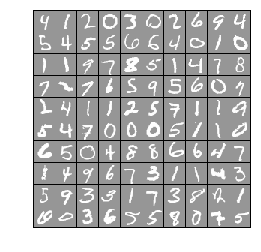

In [13]:
# affichage aléatoire de 100 images et des chiffres correspondants
rnd = np.random.permutation(X.shape[0])[0:100]
sel = X[rnd,:]
res = y[rnd]
display_data(sel, res)

## Préparation du dataset : training set / test set

In [14]:
# use the traditional train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=60000,random_state=0)

In [15]:
X.shape, y.shape

((70000, 784), (70000,))

## Fonction d'exécution générale

In [16]:
# fonction d'exécution générale

algos = [] # liste des algorithmes employés
df = pnd.DataFrame() # tableau des résultats

def run(algo):
    global algos, df
    
    start = timeit.default_timer() # start chrono

    algo.fit(X_train, y_train) # algorithme d'apprentissage automatique

    y_pred = algo.predict(X_train) # prédictions sur le train set
    acc_train = accuracy_score(y_train, y_pred)
    print("Accuracy on train set: %f" % acc_train)
    
    y_pred = algo.predict(X_test) # prédictions sur le test set
    acc_test = accuracy_score(y_test, y_pred)
    print("Accuracy on test set:  %f" % acc_test)

    stop = timeit.default_timer() # stop chrono

    # agrégation des résultats
    algos.append(algo)
    df = df.append([[algo.__class__.__name__, stop-start, acc_train, acc_test]], ignore_index=True)

## Régression logistique / Logistic Regression

Voir : http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [17]:
algo = LogisticRegression()

run(algo)

Accuracy on train set: 0.945600
Accuracy on test set:  0.900867


## Arbres de décision / Decision Tree

Voir : http://scikit-learn.org/stable/modules/tree.html


In [18]:
algo = DecisionTreeClassifier()

run(algo)

Accuracy on train set: 1.000000
Accuracy on test set:  0.805183


## Forêts d'arbres décisionnels / Random Forest

Voir : http://scikit-learn.org/stable/modules/ensemble.html#random-forests

In [19]:
algo = RandomForestClassifier()

run(algo)

Accuracy on train set: 0.998800
Accuracy on test set:  0.910567


## K plus proches voisins / K Nearest Neighbors

Voir : http://scikit-learn.org/stable/modules/neighbors.html

In [20]:
# méthode trop lente
#algo = KNeighborsClassifier(n_neighbors=10)

#run(algo)

## Algorithme du gradient stochastique / Stochastic Gradient Descent

Voir : http://scikit-learn.org/stable/modules/sgd.html

In [21]:
algo = SGDClassifier()

run(algo)

Accuracy on train set: 0.894700
Accuracy on test set:  0.864500


## Machine à vecteurs de support / Support Vector Machine

Voir : http://scikit-learn.org/stable/modules/svm.html

In [22]:
algo = LinearSVC()

run(algo)

Accuracy on train set: 0.962900
Accuracy on test set:  0.885700


## Classification naïve bayésienne / Naive Bayes

Voir : http://scikit-learn.org/stable/modules/naive_bayes.html

In [23]:
algo = MultinomialNB()

run(algo)

Accuracy on train set: 0.825400
Accuracy on test set:  0.821650


## Réseau de neuronnes / Neural Network

Voir : http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [24]:
algo = MLPClassifier()

run(algo)

Accuracy on train set: 1.000000
Accuracy on test set:  0.953767


## Synthèse des résultats

In [25]:
df.columns = ['algo', 'time', 'train', 'test']
df.sort_values(by='test', ascending=False, inplace=True)
df

,algo,time,train,test
6,MLPClassifier,15.212950,1.0000,0.953767
2,RandomForestClassifier,0.851133,0.9988,0.910567
0,LogisticRegression,6.214370,0.9456,0.900867
4,LinearSVC,6.884856,0.9629,0.885700
3,SGDClassifier,0.585451,0.8947,0.864500
5,MultinomialNB,0.155463,0.8254,0.821650
1,DecisionTreeClassifier,2.086677,1.0000,0.805183


## Affichage des datasets moyens

In [26]:
# dernier algo utilisé
algo.fit(X_train, y_train)
# prédiction sur le train set
y_pred = algo.predict(X)

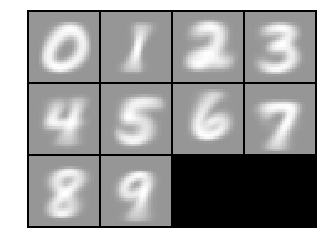

In [27]:
# display mean tagged digit set
z1 = np.concatenate([np.mean(X[y == i], axis=0) for i in range(10)])
display_data(z1.reshape((10,28*28)))

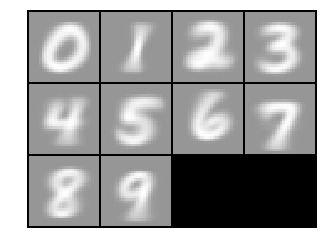

In [28]:
# display mean right recognized digit set
z3 = np.concatenate([np.mean(X[(y_pred == y) & (y == i)], axis=0) for i in range(10)])
display_data(z3.reshape((10,28*28)))

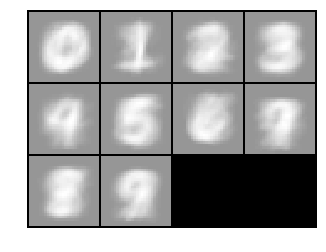

In [29]:
# display mean wrong recognized digit set
z3 = np.concatenate([np.mean(X[(y_pred != y) & (y == i)], axis=0) for i in range(10)])
display_data(z3.reshape((10,28*28)))

## Affichage de résultats sur le test set

In [30]:
# dernier algo utilisé
# prédiction sur le test set
y_pred = algo.predict(X_test)

9  6  6  7  1  8  3  4  2  5
9  4  7  1  5  8  7  6  6  0
6  9  6  1  6  2  9  9  8  8
5  1  7  2  3  9  4  6  3  6
5  1  0  5  5  4  4  0  6  7
6  5  7  8  8  1  8  2  6  4
6  3  3  6  7  2  3  6  6  5
9  1  6  6  3  8  3  8  7  9
8  7  5  2  9  0  0  1  2  4
1  3  2  9  5  2  2  8  9  3
----------------------------
.  .  .  .  .  .  .  .  .  .
.  8  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  4  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  .  .  .
.  2  .  .  .  1  .  .  .  .
.  .  .  .  .  .  .  .  .  5
.  .  .  .  .  .  .  .  .  .
.  .  .  .  .  .  .  5  .  .


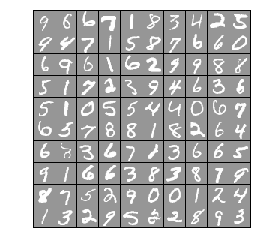

In [31]:
# affichage aléatoire de 100 chiffres et des tags associés
rnd = np.random.permutation(X_test.shape[0])[0:100]
sel = X_test[rnd,:] # 100 random digits
res = y_test[rnd]
pred = y_pred[rnd]
display_data(sel, res, pred)

## Prévisions sur une image fabriquée manuellement

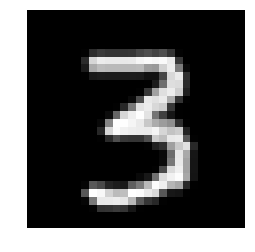

In [43]:
var = plt.imread("C:/Users/francis/Desktop/test.bmp")
plt.axis('off')
plt.imshow(var, cmap='gray');

In [38]:
var[0]

array([[  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255]], dtype=uint8)

In [44]:
# prédictions de chacun des algorithmes sur l'échantillon
sample = [var.flatten()/255]

for algo in algos:
    prediction = algo.predict(sample)[0]
    print(algo.__class__.__name__, prediction)

LogisticRegression 3.0
DecisionTreeClassifier 3.0
RandomForestClassifier 3.0
SGDClassifier 3.0
LinearSVC 3.0
MultinomialNB 3.0
MLPClassifier 3.0
